<a id="top"></a>
# UN SDG Indicator 11.3.1:<br> Ratio of Land Consumption Rate to Population Growth Rate


<hr>

# Notebook Summary
The United Nations have prescribed 17 "Sustainable Development Goals" (SDGs). This notebook attempts to monitor SDG Indicator 11.3.1 - ratio of land consumption rate to population growth rate.

UN SDG Indicator 11.3.1 provides a metric for determining wether or not land consumption is scaling responsibly with the growth of the  population in a given region.  

### Case Study

This notebook conducts analysis in the **Dar es Salaam, Tanzania** with reference years of `2000` and `2015`.

# Index

* [Define Formulas for Calculating the Indicator](#define_formulas)
* [Import Dependencies and Connect to the Data Cube](#import)
* [Show the Area](#show_area)
* [Determine Population Growth Rate](#pop_rate)
* [Determine Land Consumption Rate](#land_consumption_rate)
* [Build Composites for the First and Last Years](#false_color_composites)
* [Filter Out Everything Except the Survey Region](#filter_survey_region)
* [Determine Urban Extent](#urban_extent)
* [SDG Indicator 11.3.1](#indicator)

## <a id="define_formulas"></a>Define Formulas for Calculating the Indicator [&#9652;](#top)


>### SDG Indicator 11.3.1
> The ratio between land consumption and population growth rate.   

$$ SDG_{11.1.3} = \frac{LandConsumptionRate}{PopulationGrowthRate} $$

In [1]:
def sdg_11_3_1(land_consumption, population_growth_rate): 
    return land_consumption/population_growth_rate


>### Population Growth Rate

For calculating the indicator value for this SDG, the formula is the simple average yearly change in population.

For calculating the average yearly population growth rate as a percent (e.g. to show on maps), the following formula
is used:

### $$ PopulationGrowthRate = 10 ^ {LOG( Pop_{t_2} \space / \space Pop_{t_1}) \space / \space {y}} - 1 $$
  
Where:  

- $Pop_{t_2}$ - Total population within the area in the current/final year
- $Pop_{t_1}$ - Total population within the area in the past/initial year  
- $y$   - The number of years between the two measurement periods $t = Year_{t_2} - Year_{t_1}$ 

In [2]:
import numpy as np  

def population_growth_rate_pct(pop_t1 = None, pop_t2 = None, y = None):
    """
    Calculates the average percent population growth rate per year.
    
    Parameters
    ----------
    pop_t1: numeric
        The population of the first year.
    pop_t2: numberic
        The population of the last year.
    y: int
        The numbers of years between t1 and t2.
        
    Returns
    -------
    pop_growth_rate: float
        The average percent population growth rate per year.
    """
    return 10**(np.log10(pop_t2/pop_t1)/y) - 1
    
def population_growth_rate(pop_t1 = None, pop_t2 = None, y = None):
    """
    Calculates the average increase in population per year.
    
    Parameters
    ----------
    pop_t1: numeric
        The population of the first year.
    pop_t2: numberic
        The population of the last year.
    y: int
        The numbers of years between t1 and t2.
        
    Returns
    -------
    pop_growth_rate: float
        The average increase in population per year.
    """
    return (pop_t2 - pop_t1) / y


>### Land Consumption Rate

For calculating the indicator value for this SDG, the formula is the simple average yearly change in land consumption.

In [3]:
def land_consumption_rate(area_t1 = None, area_t2 = None, y = None):
    """
    Calculates the average increase in land consumption per year.
    
    Parameters
    ----------
    area_t1: numeric
        The number of urbanized pixels for the first year.
    area_t2: numberic
        The number of urbanized pixels for the last year.
    y: int
        The numbers of years between t1 and t2.
        
    Returns
    -------
    pop_growth_rate: float
        The average increase in land consumption per year.
    """
    return (area_t2 - area_t1) / y

## <a id="import"></a>Import Dependencies and Connect to the Data Cube [&#9652;](#top)

In [4]:
# Supress Some Warnings
import warnings
warnings.filterwarnings('ignore')
# Allow importing of our utilities.
import sys
sys.path.append("..")
# Prepare for plotting.
import matplotlib.pyplot as plt
%matplotlib inline

import datacube
dc = datacube.Datacube()

## <a id="show_area"></a>Show the Area [&#9652;](#top)

In [5]:
# Dar es Salaam, Tanzania
latitude_extents =  (-6.95, -6.70) 
longitude_extents =  (39.05, 39.45)

In [6]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude_extents, longitude = longitude_extents)

## <a id="pop_rate"></a>Determine Population Growth Rate [&#9652;](#top)

>### Load Population Data
<br>Shape files are based on GPW estimates. You can derive similar population figures from AidData GeoQuery at 
- http://geo.aiddata.org/query

In [7]:
CSV_FILE_PATH = "../data/Tanzania/population_shape/ADM2_GPWV4_population.csv"
SHAPE_FILE_PATH = "../data/Tanzania/population_shape/TZA_ADM2.geojson"

In [8]:
import geopandas as gpd
import pandas as pd

first_year, last_year = 2000, 2015
first_year_pop_col = 'gpw_v4_count.{}.sum'.format(first_year)
last_year_pop_col = 'gpw_v4_count.{}.sum'.format(last_year)

shape_data = gpd.read_file(SHAPE_FILE_PATH)
shape_data = shape_data[['Name', 'geometry']]
pop_data = pd.read_csv(CSV_FILE_PATH)
pop_data = pop_data[[first_year_pop_col, last_year_pop_col, 'Name']]
pop_data = pop_data.rename({first_year_pop_col: 'pop_t1', 
                            last_year_pop_col: 'pop_t2'}, axis='columns')
country_data = shape_data.merge(pop_data, on='Name')

In [9]:
def shapely_geom_intersects_rect(geom, x, y):
    """
    Determines whether the bounding box of a Shapely polygon intesects 
    a rectangle defined by `x` and `y` extents.
    
    Parameters
    ----------
    geom: shapely.geometry.polygon.Polygon
        The object to determine intersection with the region defined by `x` and `y`.
    x, y: list-like
        The x and y extents, expressed as 2-tuples.
        
    Returns
    -------
    intersects: bool
        Whether the bounding box of `geom` intersects the rectangle.
    """
    geom_bounds = np.array(list(geom.bounds))
    x_shp, y_shp = geom_bounds[[0,2]], geom_bounds[[1,3]]
    x_in_range = (x_shp[0] < x[1]) & (x[0] < x_shp[1])
    y_in_range = (y_shp[0] < y[1]) & (y[0] < y_shp[1])
    return x_in_range & y_in_range

# `intersecting_shapes` can be examined to determine which districts to ultimately keep.
intersecting_shapes = country_data[country_data.apply(
    lambda row: shapely_geom_intersects_rect(row.geometry, longitude_extents, latitude_extents), 
    axis=1).values]

**Show the Survey Region in the Context of the Country**

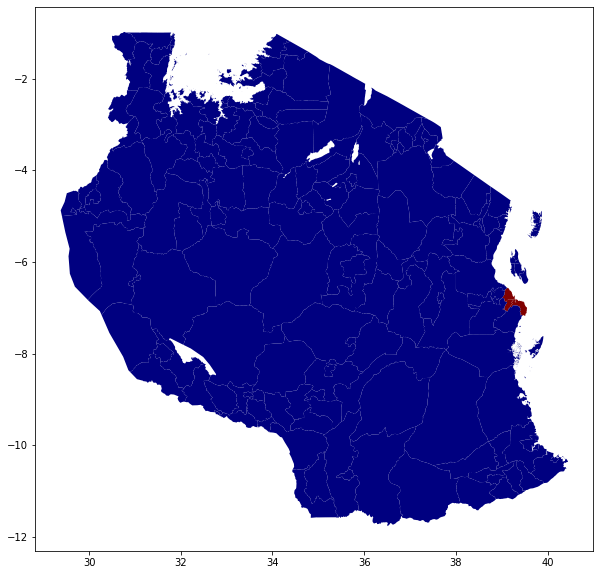

In [10]:
districts = ['Kinondoni', 'Ilala', 'Temeke']
districts_mask = country_data.Name.isin(districts)
country_data.plot(column=districts_mask, cmap='jet', figsize=(10,10))
survey_region = country_data[districts_mask]
plt.show()

**Show the Survey Region Alone**

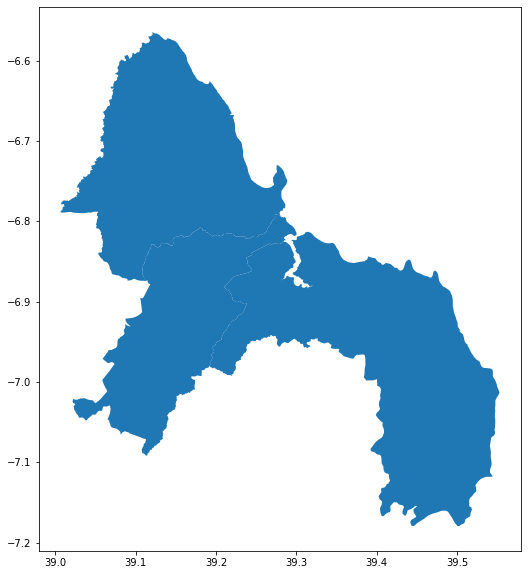

In [11]:
survey_region.plot( figsize = (10,10))
plt.show()

**Determine the Shape that Masks the Survey Region**

In [12]:
from shapely.ops import cascaded_union
disjoint_areas = cascaded_union([*survey_region.geometry]) ## Top Right is 'disjoint' from bottom left.  

>### Calculate Population Growth Rate

**Calcuate Population Growth Rate for All Regions Individually**

In [13]:
time_range = last_year - first_year
country_data = country_data.assign(population_growth_rate = \
                                   population_growth_rate_pct(country_data["pop_t1"], country_data["pop_t2"], time_range))

**Visualize Population Growth Rate**

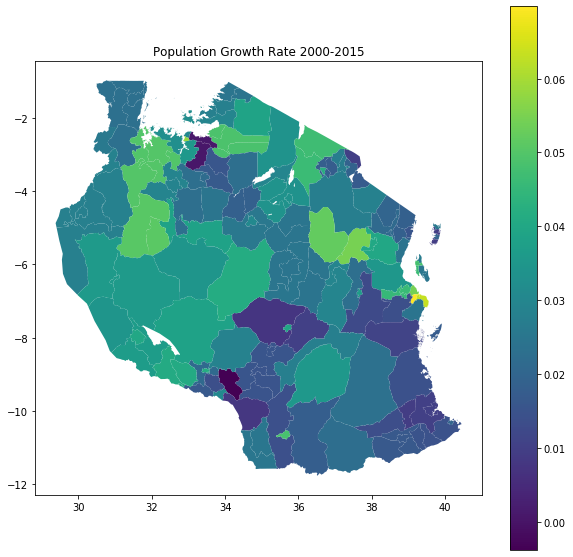

In [14]:
fig, ax = plt.subplots(figsize  = (10, 10))
ax.set_title("Population Growth Rate {}-{}".format(first_year, last_year))
ax1 = country_data.plot(column = "population_growth_rate", ax = ax, legend=True)

In [15]:
survey_region_total_pop_t1 = survey_region["pop_t1"].sum()
survey_region_total_pop_t2 = survey_region["pop_t2"].sum()

In [16]:
pop_growth = population_growth_rate(pop_t1 = survey_region_total_pop_t1,
                                    pop_t2 = survey_region_total_pop_t2,
                                    y = time_range)

In [17]:
print("Annual Population Growth Rate of the Survey Region: {:.2f} People per Year".format(pop_growth))

Annual Population Growth Rate of the Survey Region: 218786.68 People per Year



## <a id="land_consumption_rate"></a>Determine Land Consumption Rate [&#9652;](#top)

**Specify Load Parameters**

In [18]:
measurements =  ["red", "green", "blue", "nir", "swir1", "swir2", "pixel_qa"]

In [19]:
# Determine the bounding box of the survey region to load data for.
min_lon, min_lat, max_lon, max_lat = disjoint_areas.bounds
lat = (min_lat, max_lat)
lon = (min_lon, max_lon)

In [20]:
product_1 = "ls7_usgs_sr_scene" 
platform_1 = "LANDSAT_7"
product_2 = "ls8_usgs_sr_scene" 
platform_2 = "LANDSAT_8"
time_extents_t1 = ('2000-01-01', '2000-12-31')
time_extents_t2 = ('2017-01-01', '2017-03-31')

In [21]:
load_params = dict(measurements = measurements, 
                   latitude = lat, longitude = lon)

## <a id="false_color_composites"></a>Build Composites for the First and Last Years [&#9652;](#top)

In [22]:
from utils.data_cube_utilities.aggregate import xr_scale_res
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic

In [23]:
# The fraction of the original resolution to use to reduce memory consumption.
frac_res = 0.25

In [24]:
dataset_t1 = dc.load(**load_params, product=product_1, time=time_extents_t1)
dataset_t1 = xr_scale_res(dataset_t1, frac_res=frac_res)
clean_mask_t1 = landsat_qa_clean_mask(dataset_t1, platform_1)
composite_t1 = create_median_mosaic(dataset_t1, clean_mask_t1.values)
composite_t1.attrs = dataset_t1.attrs
del dataset_t1, clean_mask_t1

In [25]:
dataset_t2 =  dc.load(**load_params, product=product_2, time=time_extents_t2)
dataset_t2 = xr_scale_res(dataset_t2, frac_res=frac_res)
clean_mask_t2 = landsat_qa_clean_mask(dataset_t2, platform_2)
composite_t2 = create_median_mosaic(dataset_t2, clean_mask_t2.values)
composite_t2.attrs = dataset_t2.attrs
del dataset_t2, clean_mask_t2

> ### **First Year**
> False Color Composite [nir, swir1, blue]

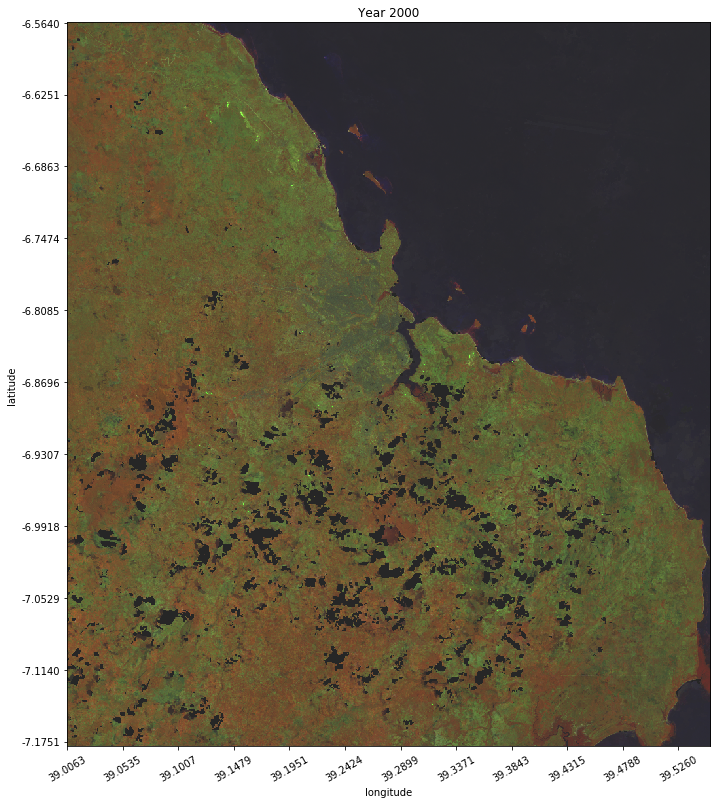

In [26]:
from utils.data_cube_utilities.dc_rgb import rgb
rgb(composite_t1, bands = ["nir","swir1","blue"], width = 15)
plt.title('Year {}'.format(first_year))
plt.show()

> ### Last Year
> False Color Composite [nir, swir1, blue]

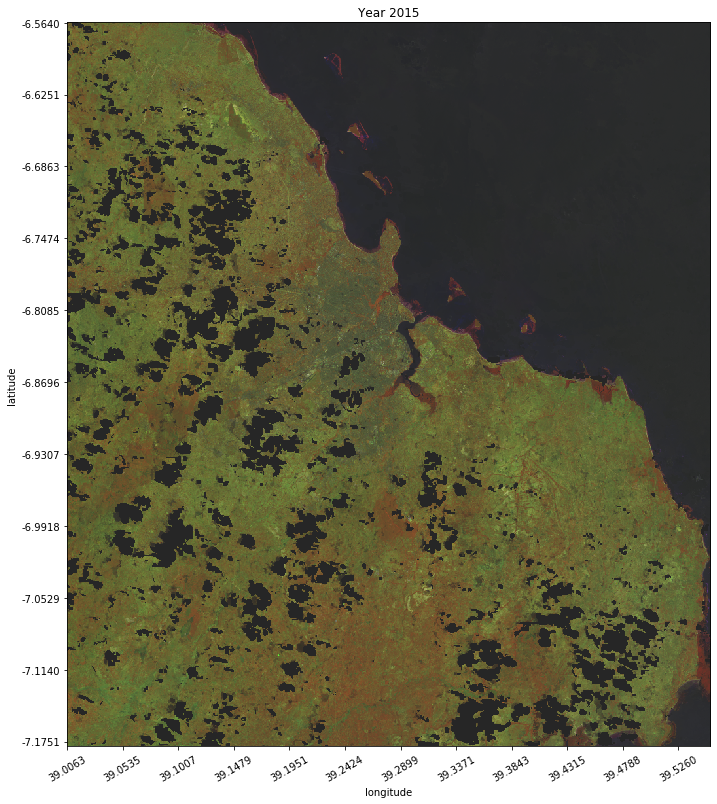

In [27]:
rgb(composite_t2, bands = ["nir","swir1","blue"], width = 15)
plt.title('Year {}'.format(last_year))
plt.show()

## <a id="filter_survey_region"></a>Filter Out Everything Except the Survey Region [&#9652;](#top)

In [28]:
import rasterio.features
from datacube.utils import geometry
import xarray as xr

def generate_mask(loaded_dataset:xr.Dataset,
                  geo_polygon: datacube.utils.geometry ):
    
    return rasterio.features.geometry_mask(
                                [geo_polygon],
                                out_shape = loaded_dataset.geobox.shape,
                                transform = loaded_dataset.geobox.affine,
                                all_touched = False,
                                invert = True)

In [29]:
mask = generate_mask(composite_t1, disjoint_areas)

In [30]:
filtered_composite_t1 = composite_t1.where(mask)
del composite_t1
filtered_composite_t2 = composite_t2.where(mask)
del composite_t2

> ### **First Year Survey Region**
> False Color Composite [nir, swir1, blue]

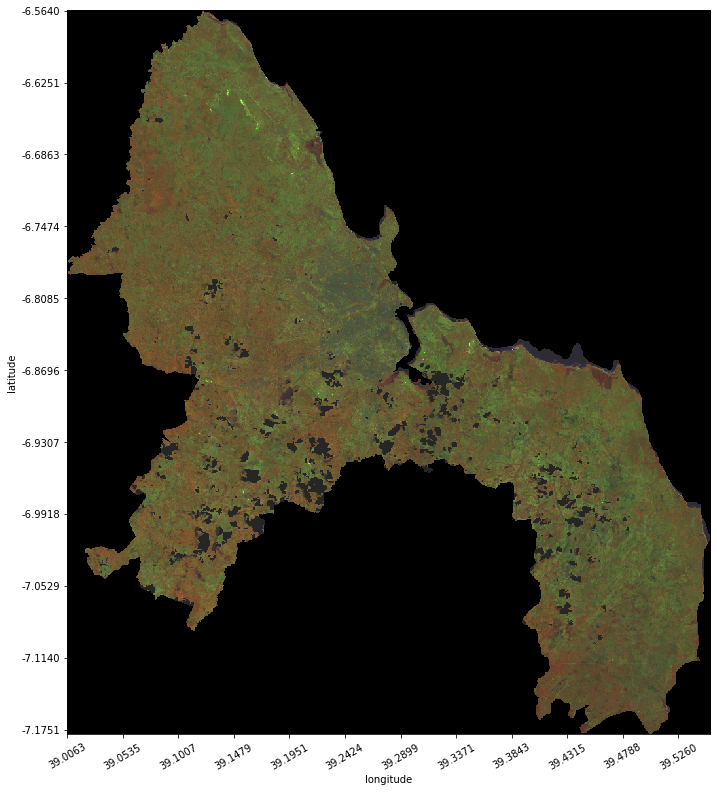

In [31]:
rgb(filtered_composite_t1, bands = ["nir","swir1","blue"],width = 15)
plt.show()

> ### **Last Year Survey Region**
> False Color Composite [nir, swir1, blue]

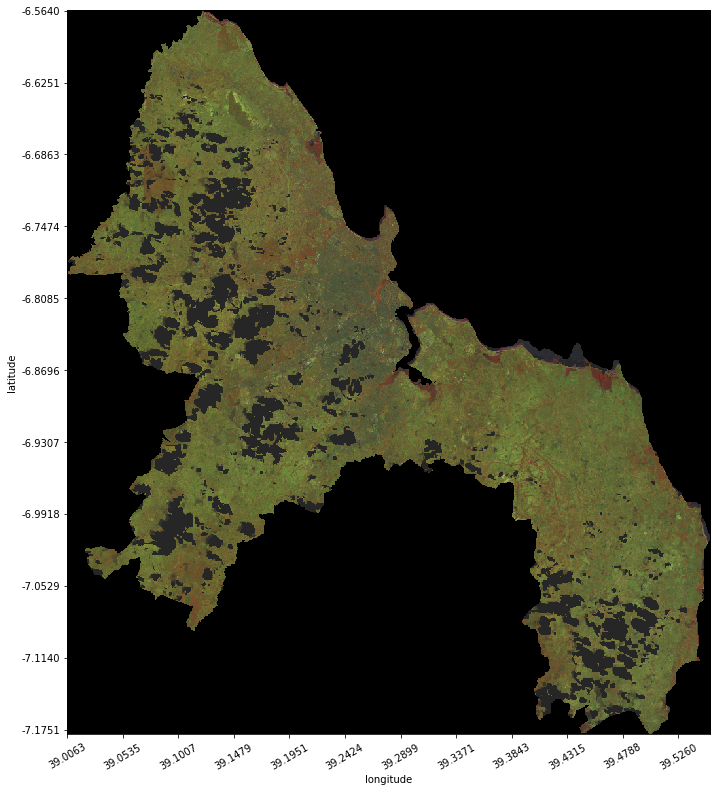

In [32]:
rgb(filtered_composite_t2, bands = ["nir","swir1","blue"],width = 15)
plt.show()

## <a id="urban_extent"></a>Determine Urban Extent [&#9652;](#top)

> ### Urbanization Index Option 1: NDBI  
> The Normalized Difference Built-up Index (NDBI) is quick to calculate, but is sometimes inaccurate (e.g. in very arid regions).

In [33]:
def NDBI(dataset):
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

> ### Urbanization Index Option 2: Fractional Cover Bare Soil
> The fractional cover bare soil index is very slow to calculate in its current implementation, but is often more accurate than NDBI.

In [34]:
from utils.data_cube_utilities.dc_fractional_coverage_classifier import frac_coverage_classify

**Choose the Urbanization Index to Use**

In [35]:
# Can be 'NDBI' or 'Fractional Cover Bare Soil'.
urbanization_index = 'Fractional Cover Bare Soil'

In [36]:
urban_index_func = None
urban_index_range = None
if urbanization_index == 'NDBI':
    urban_index_func = NDBI
    urban_index_range = [-1, 1]
if urbanization_index == 'Fractional Cover Bare Soil':
    urban_index_func = lambda dataset: frac_coverage_classify(dataset).bs
    urban_index_range = [0, 100]    
plot_kwargs = dict(vmin=urban_index_range[0], vmax=urban_index_range[1])

> ### **First Year Urban Composite**

In [37]:
urban_composite_t1 = urban_index_func(filtered_composite_t1)

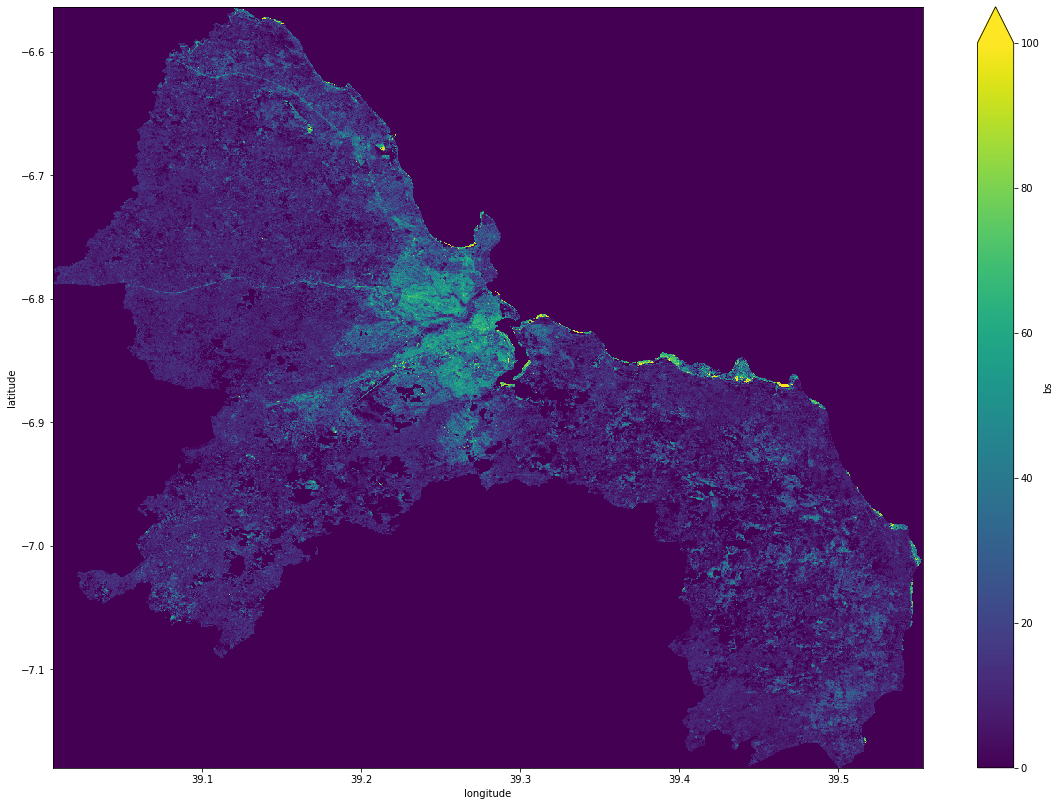

In [38]:
plt.figure(figsize = (19.5, 14))
urban_composite_t1.plot(**plot_kwargs)
plt.show()

> ### **Last Year Urban Composite**

In [39]:
urban_composite_t2 = urban_index_func(filtered_composite_t2)

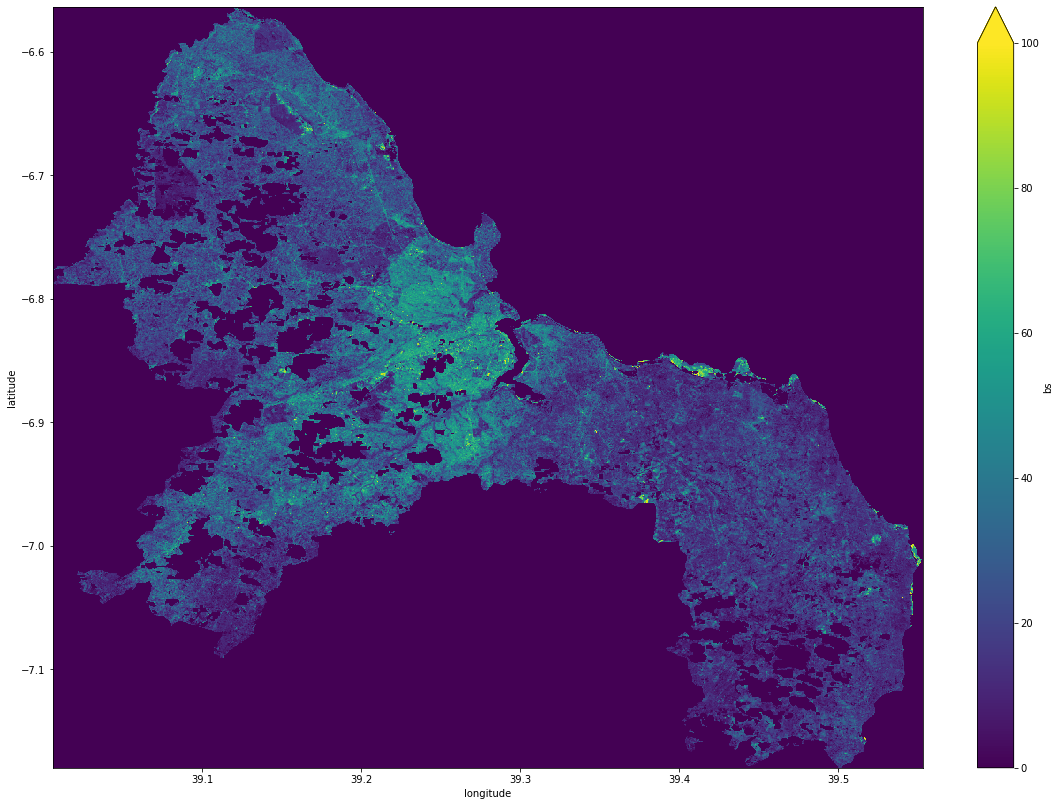

In [40]:
plt.figure(figsize = (19.5, 14))
urban_composite_t2.plot(**plot_kwargs)
plt.show()

> ### Defining Binary Urbanization

In [41]:
def urbanizaton(urban_index: xr.Dataset, urbanization_index) -> xr.DataArray:
    bounds = None
    if urbanization_index == 'NDBI':
        bounds = (0,0.3)
    if urbanization_index == 'Fractional Cover Bare Soil':
        bounds = (20, 100)
    
    urban = np.logical_and(urban_index > min(bounds), urban_index < max(bounds))
    
    is_clean = np.isfinite(urban_index)
    urban = urban.where(is_clean)
    
    return urban

In [42]:
urban_product_t1 = urbanizaton(urban_composite_t1, urbanization_index)
urban_product_t2 = urbanizaton(urban_composite_t2, urbanization_index)

> ### First Year
> Urbanization product overlayed on false color composite 

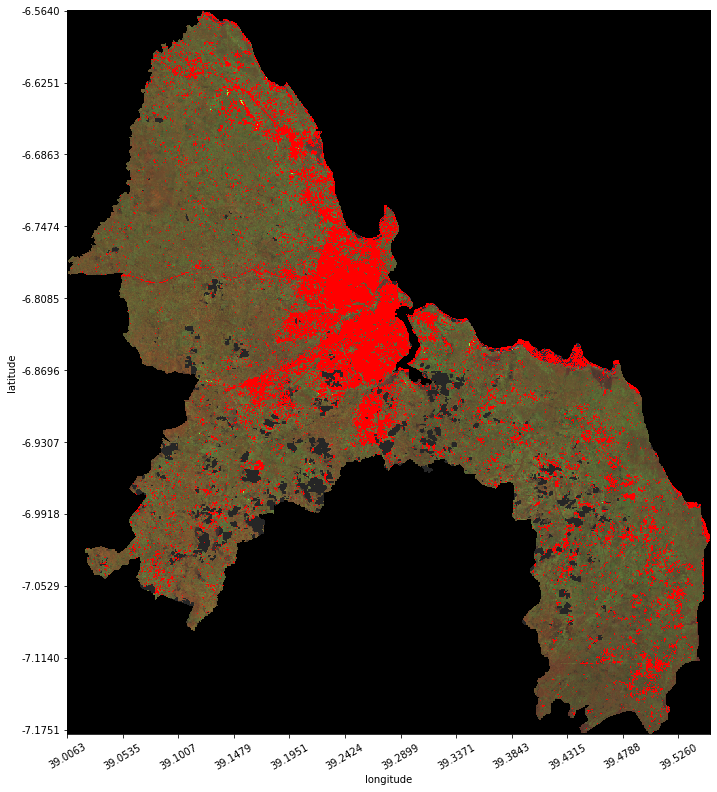

In [43]:
rgb(filtered_composite_t1, 
           bands = ["nir","swir1","blue"], 
           paint_on_mask = [(np.logical_and(urban_product_t1.astype(bool), mask), [255,0,0])],
           width = 15)
plt.show()

> ### Last Year
> Urbanization Product overlayed on false color composite 

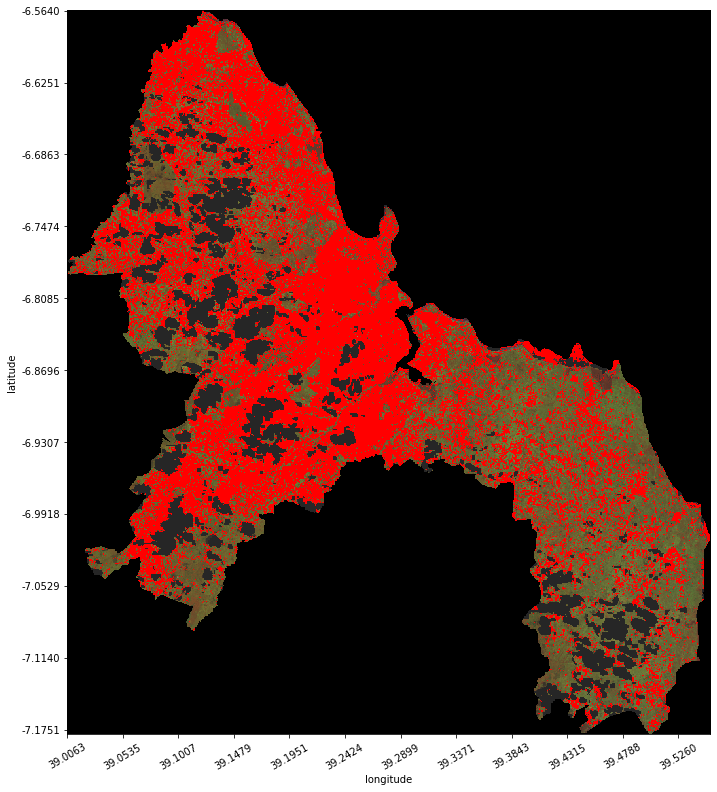

In [44]:
rgb(filtered_composite_t2,
    bands = ["nir","swir1","blue"],
    paint_on_mask = [(np.logical_and(urban_product_t2.astype(bool), mask),[255,0,0])],
    width = 15)
plt.show()

> ### Urbanization Change

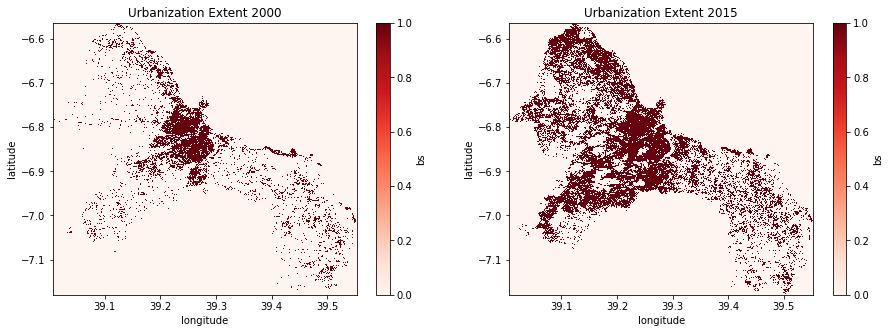

In [45]:
fig = plt.figure(figsize = (15,5))

#T1 (LEFT)
ax1 = fig.add_subplot(121)
urban_product_t1.plot(cmap = "Reds")
ax1.set_title("Urbanization Extent {}".format(first_year))

#T2 (RIGHT)
ax2 = fig.add_subplot(122)
urban_product_t2.plot(cmap = "Reds")
ax2.set_title("Urbanization Extent {}".format(last_year))

plt.show()

In [46]:
comp_lat = filtered_composite_t1.latitude
meters_per_deg_lat = 111000 # 111 km per degree latitude
deg_lat = np.abs(np.diff(comp_lat[[0, -1]])[0])
meters_lat = meters_per_deg_lat * deg_lat
sq_meters_per_px = (meters_lat / len(comp_lat))**2

In [47]:
# Calculation the square meters of urbanized area.
urbanized_area_t1 = float( urban_product_t1.sum() * sq_meters_per_px )
urbanized_area_t2 = float( urban_product_t2.sum() * sq_meters_per_px )

In [48]:
consumption_rate = land_consumption_rate(area_t1 = urbanized_area_t1, area_t2 = urbanized_area_t2, y = time_range)

In [49]:
print("Land Consumption Rate of the Survey Region: {:.2f} Square Meters per Year".format(consumption_rate))

Land Consumption Rate of the Survey Region: 30030034.28 Square Meters per Year


## <a id="indicator"></a>SDG Indicator 11.3.1 [&#9652;](#top)

In [52]:
indicator_val = sdg_11_3_1(consumption_rate,pop_growth)
print("The UN SDG 11.3.1 Indicator value (ratio of land consumption rate to population growth rate) "\
      "for this survey region for the specified parameters "\
      "is {:.2f} square meters per person.".format(indicator_val))
print("")
print("In other words, on average, according to this analysis, every new person is consuming {:.2f} square meters of land in total.".format(indicator_val))

The UN SDG 11.3.1 Indicator value (ratio of land consumption rate to population growth rate) for this survey region for the specified parameters is 137.26 square meters per person.

In other words, on average, according to this analysis, every new person is consuming 137.26 square meters of land in total.
